# Customer Segmentation using Various Clustering Methods

Customer segmentation is a tool used extensively by businesses for targeted marketing and price optimization. But segmenting (or clustering) customers is a difficult process, and often involves a number of unsupervised learning techniques which can be difficult to interpret. The Customer Personality Analysis data is a fictitious dataset which contains customer purchases by product type for a business, and a number of features about each customer which are often readily available to businesses. The purpose of this notebook is to discuss several different clustering methods that can be used in segmentation, namely K-means, hierarchical clustering, DBSCAN and Gaussian mixture model clustering.

In [ ]:
##Read in dataset, and view variables
read_data <- read.csv("/kaggle/input/customer-personality-analysis/marketing_campaign.csv", sep = "\t")

head(read_data)

In [ ]:
##Function to install and read in packages
mypack <- function(package){
  new.package <- package[!(package %in% installed.packages()[, "Package"])]
  if (length(new.package)) 
    install.packages(new.package, dependencies = TRUE)
suppressMessages(sapply(package, require, character.only = TRUE))
}

##Read in required packages
packages <- c("mice", "MASS", "dbscan","mclust", 
              "gridExtra", "cluster", "tidyverse", "fpc")
              
mypack(packages)

The original data is from Kaggle, labelled Customer Personality Analysis. It is a large dataset with 29 variables, including both categorical variables and continuous variables, with 2240 observations in total. It describes the customers of a business by various traits, and how much money they spend on various deals and products. We first cut binary categorical variables, followed by a number of others that were seemingly irrelevant to the cluster analysis or too similar to other variables. We combined the total spent on all food products into a single category, and the number of kids and teens into another single category. There were 4 clear outliers in our data that were removed, either being too high in age or salary. The MICE algorithm was employed to fill in a few missing values in our income variable.

In [ ]:
##Define variables/dataset to be used for cluster analysis

cluster_data <- data.frame(ID = rep(0, nrow(read_data)))
cluster_data$ID <- read_data$ID
cluster_data$AGE <- 2014 - read_data$Year_Birth
cluster_data$FOOD_AMOUNT <- read_data$MntFishProducts + read_data$MntFruits +
  read_data$MntMeatProducts + read_data$MntSweetProducts
cluster_data$GOLD_AMOUNT <- read_data$MntGoldProds
cluster_data$WINE_AMOUNT <- read_data$MntWines
cluster_data$DEPENDENTS <- read_data$Kidhome + read_data$Teenhome
cluster_data$INCOME <- read_data$Income

In [ ]:
##Use mice function to fill in missing values
imputed_data <- mice(cluster_data, m=5, method='pmm', seed=500)
cluster_data <- complete(imputed_data, 1)

##Remove the 4 outliers in the data
cluster_data <- cluster_data[!(cluster_data$ID == 9432), ]
cluster_data <- cluster_data[cluster_data$AGE < 100, ]

##View finalized dataset
head(cluster_data)

# Cluster Analysis

## K-Means
K-means Clustering is one of the more simple unsupervised learning techniques. Before the analysis, choose the number $k$ of clusters using various "goodness-of-fit" metrics including the gap statistic, silhouette statistic, and the elbow method. Following this, use the algorithm below:

1.   Randomly select $k$ data points as "centroids" of clusters.
2.   Choose a distance metric that best suits the data (often Euclidean distance) say $d$. For every data point $x$, assign $x$ to the cluster in which $d(x,c)$ is minimized, where $c$ represents the centroid of the cluster.
3.   Recalculate the centroid of each cluster by taking the mean of the data points assigned to it.
4.   Repeat steps 2-3 until steps either no longer change results or minimally change results. At that point, it is considered to have converged.

This method while easy to interpret, has a number of flaws. It is sensitive to the first $k$ points chosen, which often leads it to converge to local extrema. Assuming Euclidean distance is used, $k$-means is sensitive to outliers and is much less effective for non-spherical clusters.

Before choosing a $k$-means model for our standardized data, we plotted the gap statistic (Appendix A) for $k = 1, \ldots, 10$. We saw the plot flattening around $k = 4, 5$, and chose $k = 4$ after viewing the clusters graphically, as the clusters seemed more well-defined. 

In [ ]:
##Scale data for clustering
cluster_data_scaled <- scale(cluster_data[,2:7])

##Make results reproducible
set.seed(0)

##Use gap statistic to decide k
gap_stat <- suppressWarnings(clusGap(cluster_data_scaled, FUNcluster = stats::kmeans, K.max = 10, B = 50))
plot(gap_stat, main = "Gap Statistic for k Values")

kmeans_result <- kmeans(cluster_data_scaled, centers=4)

##Create data with group labels
completed_data_kmeans <- cluster_data
completed_data_kmeans$group <- as.numeric(kmeans_result$cluster)

##pca of scaled data so we can visualize
pca_result <- prcomp(cluster_data_scaled, center = FALSE, scale. = FALSE)

##Use ggplot for graph results
X <- as.data.frame(pca_result$x)
X$group <- as.character(completed_data_kmeans$group)

plot1 <- ggplot(data = X, aes(x = PC1, y = PC2)) +
  geom_point(aes(color = group)) +
  ggtitle("K-means")

## DBSCAN

Density-based spatial clustering of applications with noise (DBSCAN) uses a density-focused approach in specifying how dense data points need to be in order to be considered a cluster. Unlike $k$-means, the number of clusters is not predetermined. The algorithm requires two parameters.

  1.   $\epsilon$, the distance threshold that defines the radius within which a specified minimum number of points must lie within to be a cluster
  2.   $\textit{minPts}$, the minimum number of points required for clusters.

The process works by first finding "core points" which are points that have at least $\textit{minPts}$ within their immediate $\epsilon$ radius. Any points are considered density-reachable if there is a chain of core points connecting them, and density-connected if there exists a core point from which they are all density-reachable. DBSCAN works by connecting density-connected points. Points which are not density-connected to any core points are not assigned to clusters, and are considered "outliers". The image below shows an example of how DBSCAN is better able to pick up on well-defined non-spherical clusters than the $k$-means method.

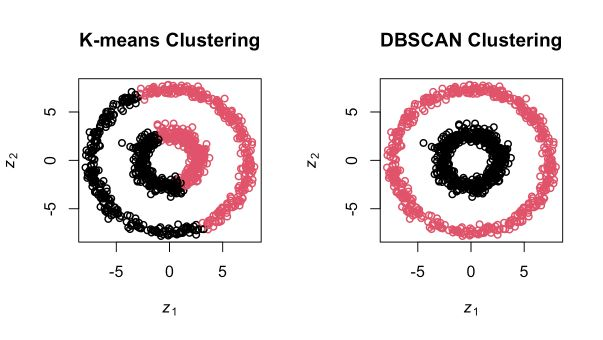

We needed to choose a value of $\epsilon$ and a value of $\textit{minPts}$. As is done for large data, we chose the standard method of taking $\textit{minPts}$ as $2$ times the number of variables used in our analysis. Our standardized dataset has $6$ variables, so we took $\textit{minPts} = 12$. To find a suitable value for $\epsilon$, we used a $k$-NN distance plot of the standardized dataset, and determined the elbow point. This gave us $\epsilon = 1.325$.

In [ ]:
##Make results reproducible
set.seed(0)

##Find elbow point to decide epsilon value
kNNdistplot(cluster_data_scaled, k = 12)
title(main = "kNN Distance Plot for DBSCAN")
abline(h = 1.325, lty = 2)

##Epsilon = 1.325, perform dbscan function
dbscan_result <- dbscan(cluster_data_scaled, eps = 1.325, MinPts = 12)

##Create data with group labels
completed_data_db <- cluster_data
completed_data_db$group <- as.numeric(dbscan_result$cluster)

##Use ggplot for graph results
X <- as.data.frame(pca_result$x)
X$group <- as.character(completed_data_db$group)

plot2 <- ggplot(data = X, aes(x = PC1, y = PC2)) +
  geom_point(aes(color = group)) +
  ggtitle("DBSCAN")


## Hierarchical Clustering

In this section, we apply agglomerative hierarchical clustering. This technique starts with each data point being considered as an individual cluster. At each iteration, similar clusters merge with other clusters until only one cluster containing all elements is formed. To compare the similarity between clusters, there were four separate methods we tried:
1.   Single Linkage: This is also called the nearest neighbour method. The distance between cluster A and cluster B is the minimum distance between a point in A and a point in B.
2.   Complete Linkage: This procedure is similar to single linkage. The only difference is that the distance between clusters A and B is defined as the maximum distance between a point in A and a point in B.
3.   Average Linkage: In this method, the distance between two clusters A and B is defined as the average of the $n_{A}n_{B}$ distances between the $n_{A}$ points and the $n_{B}$ points.
4.   Centriod Linkage: The distance between two clusters A and B is defined as the Euclidean distance between mean vectors (often called centroids) of the two clusters in this approach.

Hierarchical Clustering is easy to understand and can be visualized by dendrograms. One shortcoming of this algorithm is that it is not suitable for large datasets due to high time and space complexity.

In this study, we used the centroid linkage method. After plotting a dendrogram, the two largest vertical lines before reaching another node came at $k = 2$ and $k = 5$. We decided that separating this large data into only $2$ groups may be uninformative, so we used $5$ clusters. 

In [ ]:
##Use the centroid linkage method, others are hard to interpret
dist_matrix <- dist(cluster_data_scaled, method = "euclidean")
hc <- hclust(dist_matrix, method = "ward.D2")

##Plot dendrogram to decide number of clusters
plot(hc)
abline(h = 35, lty = 2)

##k=2 is uninteresting, so we choose k=5, the next biggest
clusters_hc <- cutree(hc, k = 5)

##Create data with group labels
completed_data_hc <- cluster_data
completed_data_hc$group <- as.character(clusters_hc)

##Use ggplot for graph results
X <- as.data.frame(pca_result$x)
X$group <- as.character(completed_data_hc$group)

plot3 <- ggplot(data = X, aes(x = PC1, y = PC2)) +
  geom_point(aes(color = group)) +
  ggtitle("Hierarchical")

## Gaussian Mixture Models
The Gaussian mixture model is a probabilistic model that represents a mixture of Gaussian normal distributions, and it is commonly used in clustering. Here are the brief steps for GMM clustering.

1.   Ensure the dataset is suitable since GMM clustering assumes that the data is generated from a mixture of Gaussian distributions.
2.   Decide on the number of clusters to identify in the data and initialize the parameters of Gaussian distributions.
3.   Use Expectation Maximization algorithm which iteratively performs two steps:

        E-step (Expectation): Compute the probability of each data point belonging to each Gaussian distribution by using Bayes' theorem.
           
        M-step (Maximization): Update the parameters (means, covariances, and weights) of the Gaussian distributions based on the assigned probabilities.


4.   Repeat the E-step and M-step until the log-likelihood of the data doesn't change significantly between iterations. After convergence, each data point is assigned to the clusters effectively.


The $k$-means algorithm can be considered as a special case of clustering with a mixture of Gaussians where all variances are equal. However, GMM clustering requires the data to follow a mixture of Gaussian normal distributions to give decent performances. 

Gaussian Mixture Models appeared to never fit this data properly. To choose a number $k$ of clusters, we attempted to minimize the Bayesian Information Criterion (BIC) using multiple values of $k$. While it was minimized for $k = 10$, this gave clusters of size $<5$, which for our dataset is uninformative. In fact, for $k>5$, we continued to get multiple extremely small clusters, so we ended up choosing $k=5$.

In [ ]:
##Make results reproducible
set.seed(0)

##Check how many clusters we should use
K <- 10
models <- lapply(1:K, function(k) Mclust(cluster_data_scaled, G = k))
bic_values <- sapply(models, function(model) BIC(model))

##k > 5 had clusters that were too small, we choose k = 5
k <- 5
gmm_model <- Mclust(cluster_data_scaled, G = k)

##Extract cluster assignments
clusters_gmm <- predict(gmm_model)$classification

##Create data with group labels
completed_data_gmm <- cluster_data
completed_data_gmm$group <- as.character(clusters_gmm)

##Use ggplot for graph results

X <- as.data.frame(pca_result$x)
X$group <- as.character(completed_data_gmm$group)

plot4 <- ggplot(data = X, aes(x = PC1, y = PC2)) +
  geom_point(aes(color = group)) +
  ggtitle("Gaussian Mixture")

# Visualization

To visualize the clusters, we conducted a principle component analysis on the standardized data. The code below shows the percentage of data variability explained by each component. 

In [ ]:
##library(factoextra) not available in this version of R, so code is commented out
##but results of running code in R Version >= 3.60 is shown below

##pca_result <- princomp(cluster_data_scaled, cor = FALSE, scores = TRUE)

##fviz_eig(pca_result, addlabels = TRUE) + 
##  theme(text=element_text(size=14))

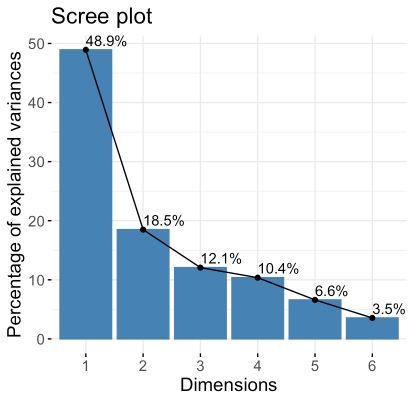

From the graph, we see that the first two components explain about 65\% of data variability. We used them to do a 2-dimensional visualization of the clusters, with understanding that it would be missing $\sim 35\%$ of the data variability. The results are shown in Figure 3.

In [ ]:
grid.arrange(plot1, plot2, plot3, plot4, ncol = 2)

Visually, $k$-means clustering looks to have the best cluster separation. It is well-divided with only some small overlap between clusters. DBSCAN seems to have nearly as good group separation, and defines the clusters quite differently. It is worth noting that "Group 0" in the DBSCAN results represents the outlier points mentioned in the methods section. GMM and hierarchical clustering seem to have created clusters with large amounts of overlap, not as convincing as the other two clustering methods.

# Goodness-of-Fit

One specific issue in clustering lies with the comparison of methods for a given dataset. Our main comparison metric used for the analysis was the silhouette width for each cluster and the average silhouette width. This provides a measure of how well each data point is classified, and how consistent the clusters are. For each data point $i \in Clus_{j}$, we calculate:

\begin{align*}
    a \left( i \right) &= \frac{1}{| Clus_{j} | - 1} \sum_{k \in Clus_{j}, k \neq i} d \left( i, k \right) \\[1em]
    b \left( i \right) &= \text{min}_{m \neq j} \frac{1}{| Clus_{m} |} \sum_{k \in Clus_{j}, k \neq i} d \left( i, k \right) \\[1em]
    s \left( i \right) &= \begin{cases}
        \frac{b \left( i \right) - a \left( i \right)}{\text{max} \left( a \left( i \right), b \left( i \right) \right)} \hspace{1cm} \text{if } | Clus_{j} | > 1 \\
        0 \hspace{2.68cm} \text{o.w.}
    \end{cases}
\end{align*}

For each data point $i$, its silhouette width is given by $s \left( i \right)$, and it is easy to see that $-1 \leq s \left( i \right) \leq 1$. Values close to $1$ represent a strong classification for point $i$, and values close to $-1$ imply that it might be unclear which cluster point $i$ should be classified in.

A large Silhouette width reflects that the object is well matched to its own cluster and poorly matched to neighbouring clusters, meaning that $k$-means clustering seems to have the best performance. The image below shows that the silhouette widths for each group are consistently greater than 0, and the average silhouette width (ASW) is maximized. Hierarchical clustering, while having a relatively high average silhouette width, has clusters where the majority of the points have a negative silhouette width.

The Silhouette width criteria gives a similar conclusion to the graphs of clustering methods in that $k$-means performs the best.

In [ ]:
##library(factoextra) not available in this version of R, so code is commented out
##but results of running code in R Version >= 3.60 is shown below

##Remove outlier points for DB clusters
##exclude_points <- which(completed_data_db$group == 0)
##data_subset <- as.data.frame(cluster_data_scaled)[-exclude_points, ]
##data_subset$group <- completed_data_db$group[-exclude_points]

##sil_widths <- silhouette(as.numeric(data_subset$group), dist(data_subset))
##silplot2 <- fviz_silhouette(sil_widths) +
##  ggtitle("DBSCAN (ASW: 0.22)")

##sil_widths <- silhouette(as.numeric(completed_data_kmeans$group), dist(cluster_data_scaled))
##silplot1 <- fviz_silhouette(sil_widths) +
##  ggtitle("K-means (ASW: 0.24)")

##sil_widths <- silhouette(as.numeric(completed_data_hc$group), dist(cluster_data_scaled))
##silplot3 <- fviz_silhouette(sil_widths) +
##  ggtitle("Hierarchical (ASW: 0.23)")

##sil_widths <- silhouette(as.numeric(completed_data_gmm$group), dist(cluster_data_scaled))
##silplot4 <- fviz_silhouette(sil_widths) +
##  ggtitle("Gaussian Mixture (ASW: 0.11)")

##grid.arrange(silplot1, silplot2, silplot3, silplot4, ncol = 2)

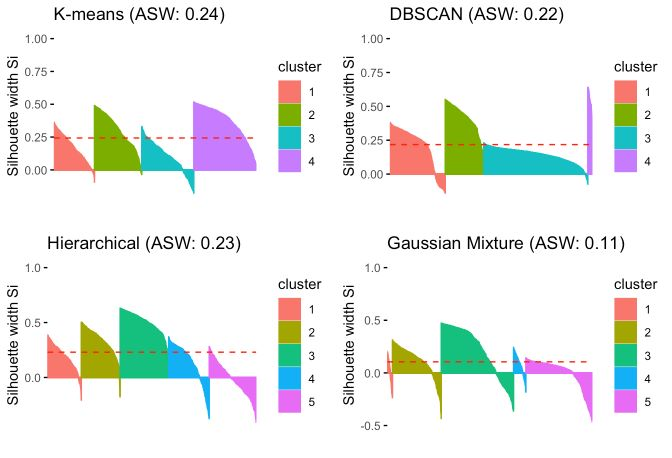

# Final Image of Clusters and Conclusion

Using the clusters from $k$-means, we examined the characteristics of each cluster. Figure 5 shows the distribution of characteristics by groups. "Total" represents the total amount of money spent at the business.

1.   Group 1 tends to have a higher salary, fewer children/dependents, and spends especially high on individual purchases (often food-related). Their age range has a high variance.
2.   Group 2 tends to have a low-to-mid level salary, more children/dependents, in the higher age range, and spend significantly less than groups 1 and 3.
3.   Group 3 tends to have a mid-to-upper level salary, in the higher age range and spends slightly less than Group 1 (but proportionally much higher on wine). The number of children they have has a high variance.
4.   Group 4 tends to have a low-level salary, fewer children/dependents, in the low age range, and often spend proportionally more on food than other groups.

From a targeted marketing perspective, this gives a whole lot of insight. For example, customers classified into group 1 should be advertised more luxurious goods (especially food-related) given their high spending reputation. Individuals classified into group 2 might be advertised more family-related cheaper alternative products, given their low salary and higher number of dependents. Group 3 customers should be advertised mid-price products but luxury wines. Individuals classified into group 4 should be advertised cheaper products, targeted at younger people. For price optimization, it seems that clusters are relatively even in size, so offering a mix of lower and higher-end products should be properly tailored to the customer base. 

In [ ]:
##We create a new dataset to visualize our clusters

read_data_kmeans <- read_data
read_data_kmeans$AGE <- 2014 - read_data$Year_Birth
read_data_kmeans <- read_data_kmeans[!(read_data_kmeans$ID == 9432), ]
read_data_kmeans <- read_data_kmeans[read_data_kmeans$AGE < 100, ]
completed_data_kmeans$group <- as.character(completed_data_kmeans$group)
completed_data_kmeans$EDUCATION <- read_data_kmeans$Education
completed_data_kmeans$RELATIONSHIP <- read_data_kmeans$Marital_Status
completed_data_kmeans$WEB_PURCHASES <- read_data_kmeans$NumWebPurchases
completed_data_kmeans$STORE_PURCHASES <- read_data_kmeans$NumStorePurchases
completed_data_kmeans$CATALOUGE_PURCHASES <- read_data_kmeans$NumCatalogPurchases
completed_data_kmeans$TOTAL <- completed_data_kmeans$FOOD_AMOUNT + completed_data_kmeans$WINE_AMOUNT + 
  completed_data_kmeans$GOLD_AMOUNT
completed_data_kmeans$TOTAL_PURCHASES <- completed_data_kmeans$WEB_PURCHASES + completed_data_kmeans$STORE_PURCHASES + 
  completed_data_kmeans$CATALOUGE_PURCHASES

compplot1 <- ggplot(data = completed_data_kmeans, aes(x = WINE_AMOUNT, y = FOOD_AMOUNT)) +
  geom_point(aes(color = group)) +
  ggtitle("Wine vs. Food") +
  theme(text=element_text(size=10))

compplot2 <- ggplot(data = completed_data_kmeans, aes(x = AGE, y = WINE_AMOUNT)) +
  geom_point(aes(color = group)) +
  ggtitle("Age vs. Wine") +
  theme(text=element_text(size=10))

compplot3 <- ggplot(data = completed_data_kmeans, aes(x = AGE, y = INCOME)) +
  geom_point(aes(color = group)) +
  ggtitle("Age vs. Income") +
  theme(text=element_text(size=10))

compplot4 <- ggplot(data = completed_data_kmeans, aes(x = DEPENDENTS, y = TOTAL)) +
  geom_jitter(aes(color = group)) +
  ggtitle("Dependents vs. Total") +
  theme(text=element_text(size=10))

compplot5 <- ggplot(data = completed_data_kmeans, aes(x = DEPENDENTS, y = INCOME)) +
  geom_jitter(aes(color = group)) +
  ggtitle("Dependents vs. Income") +
  theme(text=element_text(size=9))

compplot6 <- ggplot(data = completed_data_kmeans, aes(x = TOTAL, y = TOTAL_PURCHASES)) +
  geom_jitter(aes(color = group)) +
  ggtitle("Total vs. # of Purchases") +
  theme(text=element_text(size=10))

grid.arrange(compplot1, compplot2, compplot3, compplot4, compplot5, compplot6, ncol = 3)